In [1]:
import os
import sys
import numpy as np
import keras
# from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
seed = 273
kinase = 'cdk2'

In [3]:
#import data
smiles_lines = [line.strip().split(',') for line in open(os.path.join('data', kinase+'_smiles.csv'))]
smiles = [line[1] for line in smiles_lines]
fingerprint_lines = [line.strip().split(',') for line in open(os.path.join('data', kinase+'_fingerprints.csv'))]
fingerprints = [line[2:] for line in fingerprint_lines]
X_fingerprints = np.asarray(fingerprints, dtype=np.int16)
y = np.asarray([int(line[2]) for line in smiles_lines], dtype=np.int8)

In [4]:
#pad smiles with '!' to ensure equal length
max_smiles_len = max(len(s) for s in smiles)
smiles = [s + '!'*(max_smiles_len + 1 - len(s)) for s in smiles]

In [5]:
#one-hot vector representation of smiles
char_set = set()
for s in smiles:
    for c in s:
        char_set.add(c)
char_set = list(char_set)
char_to_index = {char_set[i]: i for i in range(len(char_set))}

X_smiles = np.zeros((len(smiles), max_smiles_len + 1, len(char_set)))
for i in range(len(smiles)):
    code = smiles[i]
    for j in range(len(code)):
        char = code[j]
        X_smiles[i, j, char_to_index[char]] = 1        

In [6]:
print(X_fingerprints.shape)
print(X_smiles.shape)
print(y.shape)

(1635, 4096)
(1635, 84, 36)
(1635,)


In [7]:
#train val test split
n_tot = X_smiles.shape[0]
n_test = round(n_tot*0.15)
n_val = round(n_tot*0.15)
n_train  = n_tot - n_test - n_val
indices = np.arange(n_tot, dtype=int)
np.random.seed(seed)
np.random.shuffle(indices)
indices_train = indices[:n_train]
indices_val = indices[n_train:n_train+n_val]
indices_test = indices[n_train+n_val:]
X_fingerprints_train = X_fingerprints[indices_train]
print(X_fingerprints_train.shape)
X_smiles_train = X_smiles[indices_train]
print(X_smiles_train.shape)
y_train = y[indices_train]
print(y_train.shape)
X_fingerprints_val = X_fingerprints[indices_val]
print(X_fingerprints_val.shape)
X_smiles_val = X_smiles[indices_val]
print(X_smiles_val.shape)
y_val = y[indices_val]
print(y_val.shape)
X_fingerprints_test = X_fingerprints[indices_test]
print(X_fingerprints_test.shape)
X_smiles_test = X_smiles[indices_test]
print(X_smiles_test.shape)
y_test = y[indices_test]
print(y_test.shape)
smiles_input_shape = X_smiles_train.shape[1:]
fingerprints_input_shape = X_fingerprints_train.shape[1:]

(1145, 4096)
(1145, 84, 36)
(1145,)
(245, 4096)
(245, 84, 36)
(245,)
(245, 4096)
(245, 84, 36)
(245,)


In [8]:
#check GPU presence
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

[]


In [9]:
#keras imports
from keras.models import Sequential
from keras.layers import TimeDistributed, GlobalAveragePooling2D, Activation, Dense, Input, Bidirectional
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, Callback, EarlyStopping
from keras.layers import Dropout, Flatten
from keras.layers import concatenate, average
from keras import regularizers
from keras import initializers
from keras import constraints
from keras.models import Model
# Backend
from keras import backend as K
# Utils
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras import metrics

In [10]:
#F1 score computation
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
npzfile = np.load('mlp_' + kinase + '.npz')
pred_train_mlp, pred_val_mlp, pred_test_mlp = npzfile['pred_train'], npzfile['pred_val'], npzfile['pred_test']
fpr_mlp_train, tpr_mlp_train, _ = roc_curve(y_train, pred_train_mlp)
auc_train = roc_auc_score(y_train, pred_train_mlp)
fpr_mlp_val, tpr_mlp_val, _ = roc_curve(y_val, pred_val_mlp)
auc_val = roc_auc_score(y_val, pred_val_mlp)
fpr_mlp_test, tpr_mlp_test, _ = roc_curve(y_test, pred_test_mlp)
auc_test = roc_auc_score(y_test, pred_test_mlp)
print('MLP Train AUC: %s' % auc_train)
print('MLP Val AUC: %s' % auc_val)
print('MLP Test AUC: %s' % auc_test)

MLP Train AUC: 0.9756288375892693
MLP Val AUC: 0.9308070175438596
MLP Test AUC: 0.9307157645666961


In [12]:
npzfile = np.load('rnn_' + kinase + '.npz')
pred_train_rnn, pred_val_rnn, pred_test_rnn = npzfile['pred_train'], npzfile['pred_val'], npzfile['pred_test']
fpr_rnn_train, tpr_rnn_train, _ = roc_curve(y_train, pred_train_rnn)
auc_train = roc_auc_score(y_train, pred_train_rnn)
fpr_rnn_val, tpr_rnn_val, _ = roc_curve(y_val, pred_val_rnn)
auc_val = roc_auc_score(y_val, pred_val_rnn)
fpr_rnn_test, tpr_rnn_test, _ = roc_curve(y_test, pred_test_rnn)
auc_test = roc_auc_score(y_test, pred_test_rnn)
print('RNN Train AUC: %s' % auc_train)
print('RNN Val AUC: %s' % auc_val)
print('RNN Test AUC: %s' % auc_test)

RNN Train AUC: 0.945664347642765
RNN Val AUC: 0.8691228070175439
RNN Test AUC: 0.8961106181603077


In [13]:
npzfile = np.load('rnn_mlp_early_' + kinase + '.npz')
pred_train, pred_val, pred_test = npzfile['pred_train'], npzfile['pred_val'], npzfile['pred_test']
fpr_rnn_mlp_early_train, tpr_rnn_mlp_early_train, _ = roc_curve(y_train, pred_train)
auc_train = roc_auc_score(y_train, pred_train)
fpr_rnn_mlp_early_val, tpr_rnn_mlp_early_val, _ = roc_curve(y_val, pred_val)
auc_val = roc_auc_score(y_val, pred_val)
fpr_rnn_mlp_early_test, tpr_rnn_mlp_early_test, _ = roc_curve(y_test, pred_test)
auc_test = roc_auc_score(y_test, pred_test)
print('RNN+MLP Early Fusion Train AUC: %s' % auc_train)
print('RNN+MLP Early Fusion Val AUC: %s' % auc_val)
print('RNN+MLP Early Fusion Test AUC: %s' % auc_test)

RNN+MLP Early Fusion Train AUC: 0.9226750467757663
RNN+MLP Early Fusion Val AUC: 0.9147368421052632
RNN+MLP Early Fusion Test AUC: 0.9031351671103225


In [14]:
npzfile = np.load('rnn_mlp_late_' + kinase + '.npz')
pred_train, pred_val, pred_test = npzfile['pred_train'], npzfile['pred_val'], npzfile['pred_test']
fpr_rnn_mlp_late_train, tpr_rnn_mlp_late_train, _ = roc_curve(y_train, pred_train)
auc_train = roc_auc_score(y_train, pred_train)
fpr_rnn_mlp_late_val, tpr_rnn_mlp_late_val, _ = roc_curve(y_val, pred_val)
auc_val = roc_auc_score(y_val, pred_val)
fpr_rnn_mlp_late_test, tpr_rnn_mlp_late_test, _ = roc_curve(y_test, pred_test)
auc_test = roc_auc_score(y_test, pred_test)
print('RNN+MLP Late Fusion Train AUC: %s' % auc_train)
print('RNN+MLP Late Fusion Val AUC: %s' % auc_val)
print('RNN+MLP Late Fusion Test AUC: %s' % auc_test)

RNN+MLP Late Fusion Train AUC: 0.9774092813661158
RNN+MLP Late Fusion Val AUC: 0.9190175438596491
RNN+MLP Late Fusion Test AUC: 0.9371487725524993


In [15]:
pred_train = (pred_train_mlp + pred_train_rnn)/2.
pred_val = (pred_val_mlp + pred_val_rnn)/2.
pred_test = (pred_test_mlp + pred_test_rnn)/2.
fpr_rnn_mlp_ens_train, tpr_rnn_mlp_ens_train, _ = roc_curve(y_train, pred_train)
auc_train = roc_auc_score(y_train, pred_train)
fpr_rnn_mlp_ens_val, tpr_rnn_mlp_ens_val, _ = roc_curve(y_val, pred_val)
auc_val = roc_auc_score(y_val, pred_val)
fpr_rnn_mlp_ens_test, tpr_rnn_mlp_ens_test, _ = roc_curve(y_test, pred_test)
auc_test = roc_auc_score(y_test, pred_test)
print('RNN+MLP Ensemble Train AUC: %s' % auc_train)
print('RNN+MLP Ensemble Val AUC: %s' % auc_val)
print('RNN+MLP Ensemble Test AUC: %s' % auc_test)

RNN+MLP Ensemble Train AUC: 0.9765495296070834
RNN+MLP Ensemble Val AUC: 0.9288421052631579
RNN+MLP Ensemble Test AUC: 0.9321206743566992


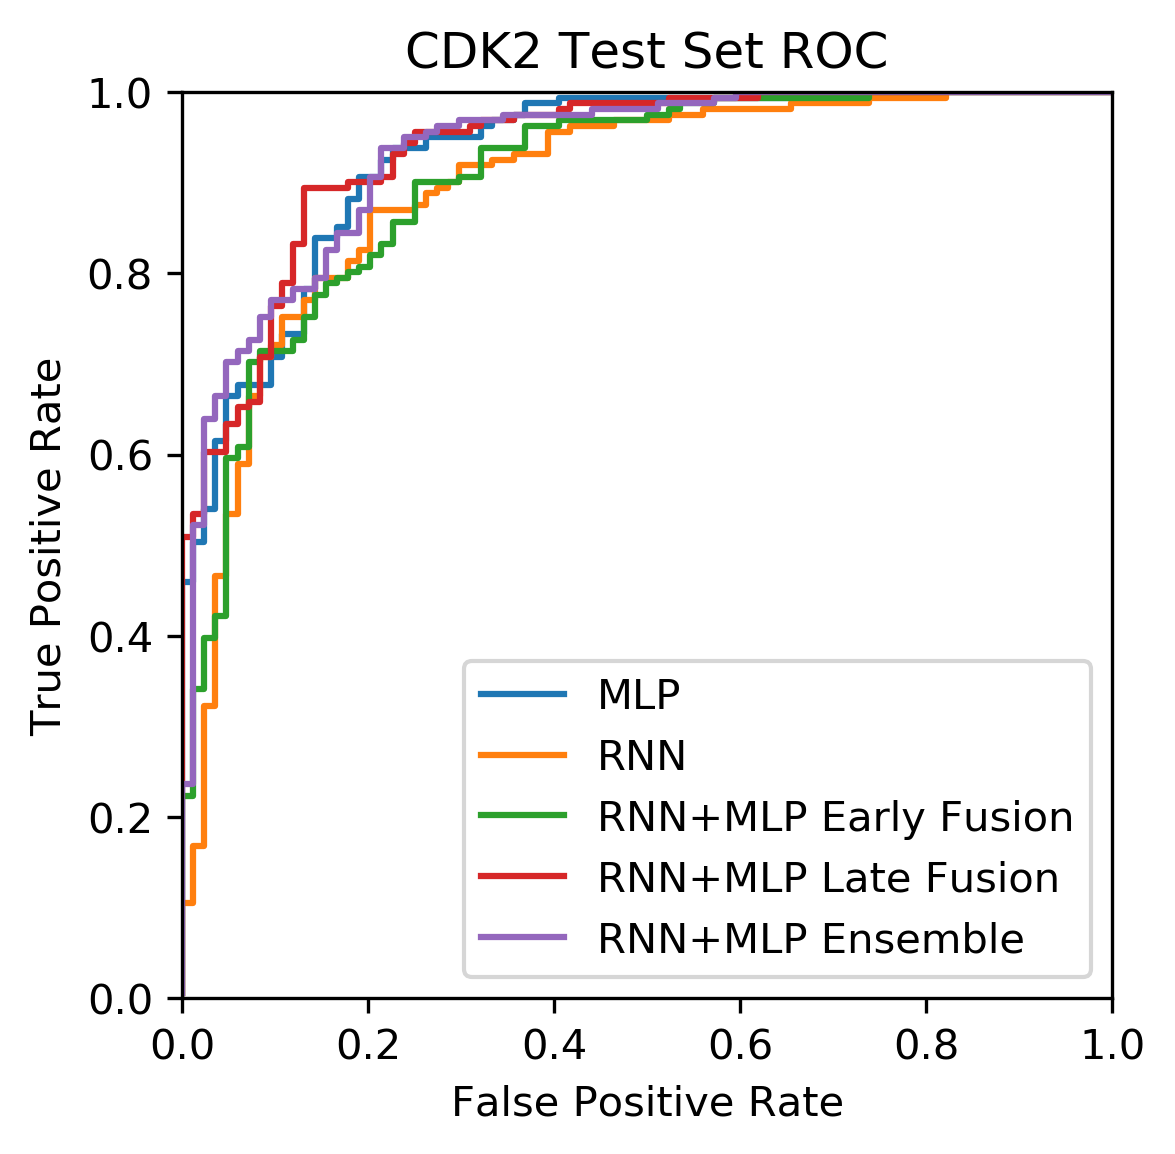

In [21]:
%matplotlib inline
from matplotlib import pyplot as plt
fig1 = plt.figure(figsize=(4,4), dpi=300)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s Test Set ROC' % kinase.upper())
plt.xlim(0,1)
plt.ylim(0,1)
plt_mlp, = plt.plot(fpr_mlp_test, tpr_mlp_test, label='MLP')
plt_rnn, = plt.plot(fpr_rnn_test, tpr_rnn_test, label='RNN')
plt_rnn_mlp_early, = plt.plot(fpr_rnn_mlp_early_test, tpr_rnn_mlp_early_test, label='RNN+MLP Early Fusion')
plt_rnn_mlp_late, = plt.plot(fpr_rnn_mlp_late_test, tpr_rnn_mlp_late_test, label='RNN+MLP Late Fusion')
plt_rnn_mlp_ens, = plt.plot(fpr_rnn_mlp_ens_test, tpr_rnn_mlp_ens_test, label='RNN+MLP Ensemble')
plt.legend(handles=[plt_mlp, plt_rnn, plt_rnn_mlp_early, plt_rnn_mlp_late, plt_rnn_mlp_ens])
fig1.savefig(os.path.join('ROC', kinase + '.png'), bbox_inches='tight')
plt.show()